<h1 style="font-size:3.2rem;color:#1351b4; text-align:center;">Pipeline de Classificação de Propostas</h1>

A plataforma do [Brasil Participativo](https://brasilparticipativo.presidencia.gov.br/processes/programas/f/2/) é uma nova aplicação digital do governo federal, software livre Decidim e um espaço para que a população possa contribuir na elaboração e votação de propostas para melhorar o serviço e definição de políticas públicas.

Por ser uma plataforma recente, ela não possui indexação automática das propostas. Isto é, não possui uma forma de categorização automatizada das propostas e o volume de propostas cadastradas até então já despende um esforço humano manual considerável. Então, o foco deste projeto é fazer uma análise das propostas por meio de processamento de linguagem natural (PLN) e automatizar esse processo de categorização. 

A partir disso, o modelo MVP (produto com mínima viabilidade) definido junto com o cliente é um sistema classificador/categorizador das propostas publicadas na plataforma, sendo as categorias baseadas nos Ministérios do Brasil (cerca de 40 categorias). Uma outra forma de categorização, baseada no tópico principal da proposta, também foi considerado e ainda é um trabalho em progresso. Além disso, foi cogitado também a adição complementar de um classificador de discurso de ódio ao pipeline do sistema, que também está em discussão.

Mais detalhes sobre o MVP do sistema abaixo.

<div style="border: thin dotted yellow; border-radius: 8px; padding-top: 15px; padding-bottom: 15px;">
Este Notebook consiste na apresentação do pipeline de desenvolvimento do projeto para o cliente.

<img style="float:left; margin: 0px 20px 5px 20px;" alt="Work in Progress" src="https://cdn-icons-png.flaticon.com/512/5578/5578703.png" width=80 height=75>

Até então, se trata de um projeto MVP, ou seja, primeira versão de modelo. Conforme a finalização dos procedimentos no repositório do GitHub, as novas informações estão sendo incrementadas ao documento. Ao final, o Notebook completo entrará como documento oficial do pipeline.
</div>

<a id='1'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Sumário</h2>

- [Extração dos dados](#data-extraction)
- [Pré-processamento textual](#pre-processing)
- [Treinamento do modelo](#training-model)
- [Utilização](#how-to-use)

<a id='data-extraction'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Extração dos Dados</h2>

A primeira etapa para o desenvolvimento do projeto é a extração dos dados. Nesta etapa é onde os dados das propostas são baixados da plataforma e o foco é garantir que os dados vazios ou repetidos não sejam repassados para próxima etapa.

A elaboração de novas propostas foram encerradas temporariamente no dia 16 de julho de 2023, junto com o Plano Plurianual ([PPA](https://www.gov.br/economia/pt-br/assuntos/planejamento-e-orcamento/plano-plurianual-ppa)) para o planejamento orçamentário do governo, delimitando uma base de dados de **8438 propostas**. Apesar da quantia ser considerável, ainda é pequena para o treinamento de um algoritmo classificador de propostas, dada a quantidade de categorias existentes e tendo em vista a desproporção de propostas por categoria.

Os dados estão disponibilizados no rodapé do site, conforme a imagem abaixo, no link "Baixar arquivos de Dados Abertos". Os arquivos com os dados das propostas (em formato `csv`) estão compactados e necessitam ser extraídos.

<img style="display:block; margin-left:auto; margin-right:auto;" src="assets/Screenshot from 2023-07-24 09-06-18.png" alt="Screenshot" width=864 height=486>

<h3 style="font-size:1.5rem;">Importação das bibliotecas</h3>

In [2]:
import pandas as pd
import os, re, io
import requests
import zipfile

Essas serão algumas das bibliotecas utilizadas no algoritmo. Dentre delas, o uso da biblioteca Pandas responsável por manipular os dados em um DataFrame e remover as colunas e linhas vazias.

As outra bibliotecas são usadas como recursos que serão esclarecidos no decorrer do pipeline. 

<h3 style="font-size:1.5rem;">Baixando <i>dataset</i></h3>

In [3]:
# Requisição ao site através do link para receber o dataset
url = "https://brasilparticipativo.presidencia.gov.br/open-data/download"
res = requests.get(url)
if res.status_code == 200:
    print("Acesso realizado com sucesso!")
else: 
    print("Falha no acesso ao arquivo zip!")

Acesso realizado com sucesso!


A biblioteca Requests é utilizada para realizar uma requisição GET no link e receber o arquivo `zip`.

<h3 style="font-size:1.5rem;">Extração do arquivo</h3>

In [4]:
# Extrai o arquivo zip do brasil participativo
with zipfile.ZipFile(io.BytesIO(res.content), 'r') as zip_ref:
    for arquivo in zip_ref.namelist():
        if arquivo.endswith('brasilparticipativo.presidencia.gov.br-open-data-proposals.csv'):
            zip_ref.extract(arquivo, 'data_extraction')
            break

O `zip` contém vários arquivos, porém busca-se extrair o `csv` que contém os dados das propostas e categorias com a biblioteca ZipFile.

<h3 style="font-size:1.5rem;">Leitura das propostas</h3>

In [5]:
# Lê as propostas com o Pandas
propostas = pd.read_csv("data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv", delimiter=";")

propostas  # Impressão do DataFrame de propostas

,id,category/id,category/name/pt-BR,scope/id,scope/name/en,scope/name/pt-BR,participatory_space/id,participatory_space/url,component/id,title/pt-BR,...,attachments,followers,published_at,url,meeting_urls,related_proposals,is_amend,original_proposal/title,original_proposal/url,category/name/en
0,1,30.0,Turismo,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Turismo: esse é o Destino,...,1,1,2023-05-10 10:03:41 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
1,8,31.0,Desenvolvimento Agrário e Agricultura Familiar,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Agricultura Familiar e Agroecologia,...,1,0,2023-05-10 16:22:51 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
2,9,1.0,Agricultura e Pecuária,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Agropecuária Sustentável,...,1,0,2023-05-10 16:35:47 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
3,10,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Atenção Primária à Saúde,...,1,515,2023-05-10 16:42:43 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
4,11,27.0,Saúde,NaN,NaN,NaN,1,http://brasilparticipativo.presidencia.gov.br/...,1,Atenção Especializada à Saúde,...,1,383,2023-05-10 16:41:01 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,11907,64.0,II - Direito à Educação,18.0,NaN,Paraná,1,http://brasilparticipativo.presidencia.gov.br/...,10,Disponibilizando mais oportunidades,...,0,1,2023-09-24 05:56:31 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
8687,11909,64.0,II - Direito à Educação,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/...,10,Programa de Fiscalização das Mensalidades do E...,...,0,5,2023-09-24 14:20:51 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
8688,11910,64.0,II - Direito à Educação,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/...,10,A inserção da juventude na educação,...,0,9,2023-09-24 15:17:05 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN
8689,11911,63.0,XII - Sistema Nacional de Juventude - SINAJUVE,1.0,NaN,Brasil,1,http://brasilparticipativo.presidencia.gov.br/...,10,Fundo Nacional das Juventudes,...,0,5,2023-09-24 16:07:13 -0300,http://brasilparticipativo.presidencia.gov.br/...,NaN,NaN,False,NaN,NaN,NaN


O arquivo `csv` precisa ser lido e, para isso, utiliza-se o pandas com a função `read_csv`.

Perceba que existem muitos dados nulos (`NaN`) e muitas colunas desnecessárias para o treinamento do modelo.

<h3 style="font-size:1.5rem;">Limpeza e seleção das colunas</h3>

In [6]:
# Seleciona apenas as colunas importantes
propostas = pd.DataFrame(propostas, columns=['category/name/pt-BR','title/pt-BR','body/pt-BR'])
propostas.rename(columns={'category/name/pt-BR': 'Categoria', 'title/pt-BR': 'Título', 'body/pt-BR': 'Corpo'}, inplace=True)

# Retira as linhas que estao vazias
propostas = propostas.dropna()
propostas.drop(propostas[propostas['Título'] == 'Tema '].index, inplace=True)  # Removendo coluna "Tema "

# Une as colunas de Título e Corpo em uma única coluna e exclui as antigas 
propostas['Texto'] = propostas['Título'] + '. ' + propostas['Corpo']
propostas = propostas[['Categoria', 'Texto']]
propostas.head()  # Impressão das cinco primeiras linhas de propostas

,Categoria,Texto
0,Turismo,Turismo: esse é o Destino. <p><strong>Objetivo...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. <p><stron...
2,Agricultura e Pecuária,Agropecuária Sustentável. <p>Objetivo: Contrib...
3,Saúde,Atenção Primária à Saúde. <p>Fortalecer a Aten...
4,Saúde,Atenção Especializada à Saúde. <p>Ampliar o ac...


Os dados contidos na variável “propostas” são então tratados para conter apenas as informações necessárias para classificação das propostas. Apenas três colunas são necessárias: o **título** da proposta, mesclada com o **corpo** (descrição da proposta); e a **categoria** à qual ela pertence. Por fim, é realizado a limpeza das linhas com valores em branco.

In [7]:
print(f'Após a remoção dos valores nulos, sobraram {len(propostas)} propostas.')

Após a remoção dos valores nulos, sobraram 8674 propostas.


Podemos vizualizar a distribuição das propostas em suas categorias no gráfico abaixo. Perceba que a quantidade de propostas por categoria é desproporcionalmente distribuído; isso é natural de ocorrer. Todavia, para treinamento de um classificador, é necessário uma boa quantidade de dados. Logo, as categorias com menos dados não terão uma performance muito boa. 

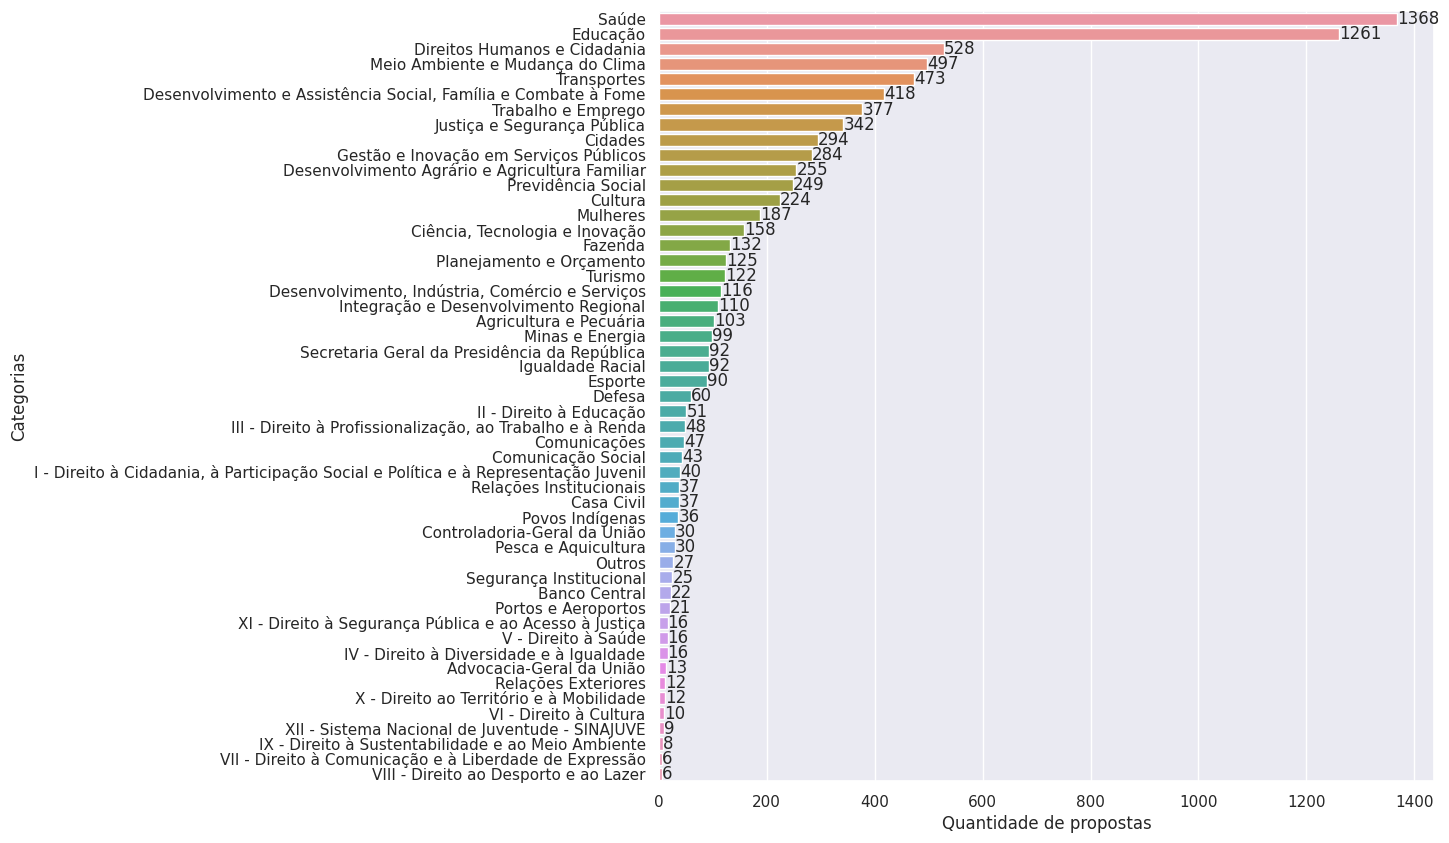

In [8]:
# Biblioteca pra visualização de gráficos
import seaborn as sns

sns.set(font_scale=1.0) # Definindo tamanho da fonte
counts = propostas.groupby(["Categoria"])["Categoria"].count()  # Contando valores por categoria
counts.sort_values(ascending=False, inplace=True) # Ordenando valores

ax = sns.barplot(y=counts.index, x=counts)  # Criando gráfico
ax.set(xlabel='Quantidade de propostas', ylabel='Categorias') # Labels do gráfico
for i in ax.containers: # Valores das barras
    ax.bar_label(i,)
ax.figure.set_size_inches(10, 10) # Definição do tamanho do gráfico

<h3 style="font-size:1.5rem;">Criação do arquivo com as alterações e remoção do anterior</h3>

In [9]:
# Retorna o novo csv limpo
propostas.to_csv('data_extraction/propostas.csv', index=False)

# Remove o csv antigo 
os.remove('data_extraction/brasilparticipativo.presidencia.gov.br-open-data-proposals.csv')

Por último, cria-se um novo arquivo `csv` com as alterações feitas e o arquivo original é removido. O novo arquivo criado parte para a etapa de pré-processamento dos dados. 

<a id='pre-processing'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Pré-processamento Textual</h2>

Nesta etapa de pré-processamento, o objetivo é manipular as informações importantes para que o algoritmo de Machine Learning consiga entender e ser treinado. Algoritmos de Machine Learning não entendem dados textuais (não estruturados) e necessitam que eles sejam estruturados de forma que possam ser utilizados para treinamento. Para isso, os dados textuais serão mais uma vez processados, desta vez para gerar uma representação vetorial, conhecido como _Word Vector_ ou _Word Embedding_.

Além disso, nesta etapa, os dados serão trabalhados para otimização do modelo. Retirando palavras do texto que possuam baixo valor semântico para o processo de aprendizado de máquina. Essa limpeza é necessária para aumentar a precisão dos resultados do modelo treinado.

Um [_Word Vector_](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) ([aqui](https://dzone.com/articles/introduction-to-word-vectors) também) é nada mais do que uma vetor numérico de pesos ou ocorrências que busca aproximar o significado de uma palavra dado o vocabulário ao qual ele pertence e o contexto no qual ele é utilizado. Existem várias técnicas para isso (_Bag of Words_, _Word2Vec_, _TF-IDF_, _GloVe_, ...) e geralmente se utiliza de conceitos comuns em Machine Learning como Redes Neurais e Redução de Dimensionalidade na matriz de coocorrência de palavras, ou então modelos probabilísticos, métodos de base de conhecimento explicável até mesmo uma representação explícita com base no contexto em que a palavra aparece.

No caso do spaCy, o modelo de pipeline em português possui a capacidade de representação vetorial a partir do modelo médio (`pt_core_news_md`), com o uso da técnica _GloVe_. A quantidade de chaves e vetores únicos diferem para cada pipeline do spaCy e, caso alguma palavra não se encontre no vocabulário, é atribuído a ela um vetor com valores nulos. Os vetores das palavras possuem, por sua vez, um tamanho fixo 300 de dimensionalidade para todos os pipelines (cada dimensão inferindo uma informação contextual na qual tal palavra é utilizada). Além disso, é possível obter o vetor de uma sentença a partir da média dos valores de cada vetor de palavra contido nela. Mais detalhes podem ser encontrados na [documentação](https://spacy.io/api/vectors) ([aqui](https://spacy.io/usage/linguistic-features#vectors-similarity), [aqui](https://spacy.io/api/doc#vector) e [aqui](https://spacy.io/api/doc#vector))

<h3 style="font-size:1.5rem;">Definições iniciais</h3>

Nas definições iniciais, é declarado duas variáveis para expressões regulares e é instanciado o pipeline em português da biblioteca spaCy. Essas definições serão utilizadas na função de pré-processamento.

In [10]:
# Expressões regulares para remoção de poluição de dados nos textos 
# REGX_URL = r"https?://[A-Za-z0-9./\-]+" # Regex for URLs
REGX_HTML = r"<[^<]+?>" # Regex for HTML tags
REGX_ENDING = r'Órgão Responsável:.+' # Regex for the part of the text

In [11]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

# Instanciando o pipeline em português do spaCy
# nlp = spacy.blank('pt') # Pipeline vazio para teste (apenas tokenização)
# nlp = spacy.load('pt_core_news_sm')   # Pipeline pequeno (para eficiência), não possui vector (?)
# nlp = spacy.load('pt_core_news_md')   # Pipeline médio, com vector (500k keys, 20k unique vectors, 300 dimensions)
nlp = spacy.load('pt_core_news_lg')   # Pipeline grande (para precisão), com vector (500k keys, 500k unique vectors, 300 dimensions)

2023-09-25 13:05:20.237274: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 13:05:20.267559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 13:05:20.772838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/chaydson/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook

O [spaCy](https://spacy.io/usage/spacy-101) é uma biblioteca gratuita e _open source_ para Processamento de Linguagem Natural avançado em Python. Foi especificamente projetada para uso em produção e para auxiliar na criação de aplicações que processam e "entendem" grandes volumes de texto. Ela pode ser usada para realizar a extração de informações, construir sistemas de compreensão de linguagem natural ou para pré-processar texto para modelos de Machine Learning e Deep Learning.

<h3 style="font-size:1.5rem">Pré-processamento</h3>

Primeiro, é preciso indexar cada uma das categorias. Isto é, atribuir um valor númerico que identifique unicamente cada uma das categorias existentes.

In [12]:
#Criando índices para as categorias
cats = propostas['Categoria'].unique() # Pegando cada categoria única
cats = dict(enumerate(cats, 0)) # Convertendo para dict (com índices enumerados)
cats = {v:k for k,v in cats.items()}  # Trocando chaves e valores

propostas['id_cats'] = propostas['Categoria'].map(cats) # Inserindo coluna de índices das cats
propostas.head()

,Categoria,Texto,id_cats
0,Turismo,Turismo: esse é o Destino. <p><strong>Objetivo...,0
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. <p><stron...,1
2,Agricultura e Pecuária,Agropecuária Sustentável. <p>Objetivo: Contrib...,2
3,Saúde,Atenção Primária à Saúde. <p>Fortalecer a Aten...,3
4,Saúde,Atenção Especializada à Saúde. <p>Ampliar o ac...,3


Em seguida, como pode-se perceber na coluna de texto, existem informações de tags HTML e informações ao final do texto que fogem do conteúdo das propostas. Para limpar essas informações, é definido uma função "preprocessing" que aplicará as modificações desejadas em cada linha do DataFrame.

In [13]:
# Para visualização do conteúdo da coluna "Texto" em uma proposta
print("ANTES DO PRÉ-PROCESSAMENTO")
print(f'{propostas["Texto"].iloc[0]}')

ANTES DO PRÉ-PROCESSAMENTO
Turismo: esse é o Destino. <p><strong>Objetivo:</strong> Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.<br><br><strong>Órgão Responsável:</strong> Ministério do Turismo<br><br><strong>Página Oficial: </strong>https://www.gov.br/turismo/pt-br/</p>


In [14]:
# Função para pré-processamento
def preprocessing(text):
  # text = text.lower()

  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  # text = re.sub(REGX_URL, '', text) # Revomendo URLs
  text = re.sub(REGX_ENDING, '', text)

  # tokens = [t.lemma_ for t in nlp(text) if t not in STOP_WORDS and not t.is_punct]

  return text

#  Ajustando textos da coluna Corpo
propostas['Texto'] = propostas['Texto'].apply(preprocessing)
propostas.head()

,Categoria,Texto,id_cats
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3


In [15]:
# Agora com o texto filtrado
print("DEPOIS DO PRÉ-PROCESSAMENTO")
print(f'{propostas["Texto"].iloc[0]}')

DEPOIS DO PRÉ-PROCESSAMENTO
Turismo: esse é o Destino. Objetivo: Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.


Enfim, criamos uma representação vetorial do texto a partir da biblioteca spaCy e guardamos os vetores em uma nova coluna chamada "Vector".

In [100]:
#  Representações vetoriais do texto
propostas['Vector'] = propostas['Texto'].apply(lambda text: nlp(text).vector)
propostas.head()


,Categoria,Texto,id_cats,Vector
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,"[0.85847634, -0.37545732, 0.07612456, -0.90006..."
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,"[0.4189733, -1.3273121, -0.14920743, -1.345308..."
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,"[1.0754207, -0.7153076, -0.023167895, -1.01495..."
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,"[0.68205523, -0.8182749, -0.11555423, -1.60916..."
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,"[0.7731693, -0.5005779, 0.4960923, -0.6091388,..."


In [111]:
print(propostas['Texto'][17])

2                                Agricultura e Pecuária
3                                                 Saúde
4                                                 Saúde
5                                          Comunicações
6     Desenvolvimento e Assistência Social, Família ...
7                                       Minas e Energia
8                                    Trabalho e Emprego
9                           Justiça e Segurança Pública
10                                     Igualdade Racial
11    Desenvolvimento e Assistência Social, Família ...
12                         Direitos Humanos e Cidadania
13                                              Fazenda
14                                  Pesca e Aquicultura
15                       Ciência, Tecnologia e Inovação
16      Desenvolvimento, Indústria, Comércio e Serviços
17                                             Educação
18                                             Mulheres
19                                              

Ao final do pré-processamento, nota-se que algumas alterações foram feitas na tabela, entre elas, a remoção de tags HTML e textos com baixo valor semântico. Houve também a criação de duas novas colunas “id_cats”, responsável por enumerar os índices de categorias (do 0 ao 39) e a coluna “Vector” que representa a vetorização das sentenças.

Com os dados processados, é possível então treinar um algoritmo de Machine Learning para classificação.

<a id='training-model'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Treinamento do Modelo</h2>

O modelo ML utilizado neste MVP para classificação de propostas foi determinado através de um benchmark de vários algoritmos. Os algoritmos foram avaliados com base na sua precisão e tempo de treinamento, duas métricas para examinar qual modelo se adequa às necessidades e exigências do cliente. Dos algoritmos estudados, a maioria foi implementado com a biblioteca do Scikit-Learn, com exceção de dois. Os algoritmos são os seguintes:
- Random Forest
- Nearest Neighbors
- Support Vector Machine
- Multinomial Naive Bayes
- Rede Neural Profunda do Tensorflow
- TextCat do spaCy

Desta forma, optou-se por utilizar Support Vector Machine ([SVM](https://scikit-learn.org/stable/modules/svm.html#support-vector-machines)) por exibir melhor precisão e menor tempo de treinamento. O benchmark foi realizado em um [dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset) diferente (com mais dados para treinamento, mesmo assim, com o formato de dados semelhantes com os dados das propostas) e posteriormente no dataset de propostas do Brasil Participativo.

<h3 style="font-size:1.5rem">Importando bibliotecas</h3>

A biblioteca do Scikit-Learn possui vários módulos úteis para realização do treinamento de um algoritmo de Machine Learning, como funções para avaliar a precisão, formas de otimização do algoritmo. pré-processamento e outros além do próprio algoritmo utilizado.

In [17]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, model_selection
import numpy as np

<h3 style="font-size:1.5rem">Configurações do modelo</h3>

Primeiramente, os dados das propostas (colunas "Vector" e "id_cats") são parametrizados pelo Scikit-Learn. O dataset é embaralhado e dividido em dados para treinamento e testem, sendo 70% utilizado para treinamento e 30% para teste, e em seguida, são aplicadas duas transformações.

In [42]:
# Separação dos dados para treinamento e teste
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    propostas.Vector.values,
    propostas.Categoria,
    test_size=0.3
)

# Transformação: conversão do tipo dos dados de entrada (X) para interpretação
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

# Transformação: escalonamento dos dados numéricos (normalizados entre 0 e 1)
# Para tratamento de casos outliers
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


Vector 
 [ 8.58476341e-01 -3.75457317e-01  7.61245564e-02 -9.00064886e-01
 -6.11441076e-01  1.25530511e-01 -6.27642274e-01 -7.21851945e-01
 -2.18857718e+00 -2.58250892e-01 -4.92234379e-02 -1.19453740e+00
  1.07141793e+00 -6.70423284e-02 -9.67239678e-01  4.69809920e-01
  6.85030341e-01  8.11600327e-01  5.69168210e-01  1.64064360e+00
  4.64841455e-01 -9.42136645e-01  1.49884969e-01  3.88309717e-01
  9.37318623e-01 -9.81622487e-02  5.27023494e-01  1.05195820e+00
  1.53949738e-01  6.31461263e-01 -1.61632106e-01 -4.94580656e-01
 -1.26311195e+00 -1.44451106e+00 -1.07531093e-01 -6.80927038e-01
 -5.43854237e-01 -6.75390661e-01  1.34924936e+00 -3.27608496e-01
 -8.98819387e-01  1.27216768e+00  1.19763386e+00 -2.22519994e-01
 -3.48081529e-01 -1.08920610e+00 -9.03657794e-01  1.30505681e-01
  1.66673625e+00 -1.64343789e-01  7.74485320e-02 -1.15414536e+00
 -9.55904901e-01 -6.49522901e-01 -1.09417617e+00  5.08220196e-01
  1.32383478e+00 -8.95446360e-01  2.04769731e-01 -6.45716310e-01
  1.05439723e+00

Agora, o modelo é instanciado, realizado o treinamento com a função `fit`. Em seguida, os dados de teste são utilizados para imprimir um relatório com a performance em cada categoria e sua perfomance geral. O relatório também pode ser encontrado em `assets/training_results`.

In [19]:
import json

# Treinamento
clf = svm.SVC() # Instanciando modelo
clf.fit(scaled_train_embed, Y_train)  # Realização do treinamento passando os dados

Y_pred = clf.predict(scaled_test_embed) # Predição com os dados de teste

# Salvando relatório de treinamento em um arquivo JSON
json_obj = json.dumps(classification_report(Y_test, Y_pred, output_dict=True), indent=4)
save_file = open('model/training_results.json', 'w').write(json_obj)

# Impressão do relatório com as métricas do modelo (para cada cat.)
print(classification_report(Y_test, Y_pred))  

predictions_SVM = clf.predict(scaled_test_embed)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Y_test)*100)  # Impressão da precisão geral

/home/chaydson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chaydson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chaydson/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chaydson/.local/lib/pytho

                                                                                     precision    recall  f1-score   support

                                                           Advocacia-Geral da União       0.00      0.00      0.00         4
                                                             Agricultura e Pecuária       0.00      0.00      0.00        38
                                                                      Banco Central       0.00      0.00      0.00         8
                                                                         Casa Civil       0.00      0.00      0.00        12
                                                                            Cidades       0.32      0.29      0.31        79
                                                     Ciência, Tecnologia e Inovação       0.39      0.15      0.22        46
                                                                 Comunicação Social       0.00      0.00      0.00        13

Algumas observações a se destacar é que o modelo MVP ainda não atinge uma performance alta o suficiente para utilização em produção. A precisão geral (_accuracy score_) do algoritmo é de 49%, em certas categorias atinge uma métrica satisfatória acima dos 85%, porém em outras não consegue inferir corretamente se alguma proposta pertence a tal categoria.

Isso se deve primeiramente pelo pouco volume de dados presentes no dataset do Brasil Participativo. As categorias com menos propostas não possuem uma quantia suficiente para treinar e avaliar a performance do algoritmo.

Apesar disso, algumas otimizações estão previstas para serem realizadas no algoritmo. Dentre elas, a utilização de diferentes técnicas de pré-processamento e o emprego de um outro algoritmo que necessite poucos dados para treinamento serão os focos para otimização do MVP.

<a id='how-to-use'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Utilização</h2>

Com o modelo treinado, é possível então carregá-lo em um arquivo serializado para persistência e utilização futura, acoplado a um outro sistema por exemplo.

Existem várias formas de serializar um objeto Python (o modelo MVP treinado, no caso). As formas mais comuns de serem utilizadas é através das bibliotecas Pickle (nativa do Python) ou Joblib (que utiliza a anterior). Detalhes para a serialização com elas podem ser vistas [aqui](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/). Apesar de serem as mais comuns, o Scikit-Learn aponta algumas [limitações de segurança e mantenibilidade](https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations) e por conta disso, será utilizado a biblioteca [Skops](https://skops.readthedocs.io/en/stable/), mais recomendada.

O Skops fornece um formato mais seguro, evitando o uso de Pickle e carregando apenas arquivos que possuem tipos e referências a funções nas quais são confiáveis por padrão ou pelo desenvolvedor Além disso, o seu uso é muito semelhante ao uso do Pickle.

Além desta forma de reuso e utilização do modelo, está em avaliação e desenvolvimento uma forma de integração do modelo treinado com uma aplicação Ruby on Rails, visto que o sistema do Brasil Participativo é implementado com essa tecnologia.

<h3 style="font-size:1.5rem">Serialização</h3>

Para a serialização, é utilizado a função `dump` passando o modelo treinado e o caminho junto com o nome do arquivo onde será salvo o modelo serializado.

<h3 style="font-size:1.5rem">Carregamento</h3>

Para recarregar o modelo em algum sistema, utiliza-se a função `load` ou `loads`. Antes disso, é preciso especificar os tipos confiáveis ou então carregar o modelo passando o parâmetro `trusted=True`.

In [20]:
from skl2onnx import to_onnx

onx = to_onnx(clf, scaled_train_embed)

[[0.4671943  0.41636923 0.52937376 ... 0.3448011  0.46916354 0.63044715]
 [0.37374455 0.47736442 0.3900659  ... 0.38311315 0.4690868  0.6318248 ]
 [0.5238726  0.51688826 0.3188     ... 0.30127513 0.6365249  0.50207835]
 ...
 [0.3360772  0.44607398 0.44902402 ... 0.41161925 0.44164088 0.69009674]
 [0.2468532  0.460513   0.45914093 ... 0.24419683 0.6221626  0.5853153 ]
 [0.43974584 0.44289094 0.5712981  ... 0.26044145 0.6076651  0.71236587]]


In [21]:
with open("exported_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [75]:
import onnxruntime as rt

sess = rt.InferenceSession("exported_model.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name


pred_onx = sess.run([label_name], {input_name: [scaled_test_embed[2602]]})[0]

print(pred_onx)

['Justiça e Segurança Pública']


<a id='how-to-use'></a><h2 style="padding:10px;background:#1351b4;margin:10;color:white;font-size:3rem;text-align:center;border-radius: 1px 1px;overflow:hidden;font-weight:100">Histórico de versão</h2>

| Data       | Autor                                        | Modificações                          | Versão |
| ---------- | -------------------------------------------- | ------------------------------------- | ------ |
| 15/08/2023 | [Alexandre Oliveira](https://github.com/LexTOliver) | Primeira versão | 1.0    |